In [1]:
# uses a simpler network that only has one block
# mainly based off mscalev3 with some changes

In [10]:
from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa
import tensorboard as tb
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [13]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

def plot_fft(x, y, model=None, xlim=None, logx=False, logy=False):
    xf, yf = compute_fft(x[:,0], y[:,0])
    
    plt.figure(figsize=(14, 6))
    plt.plot(xf, np.abs(yf), label='total')
    
    if model is not None:
        plt.plot(xf, np.abs(compute_fft(x[:,0], model.predict(x)[:,0]))[1], ls='--', label='model', c='k')
        
    plt.axvline(1, c='k', ls='--')
    plt.axvline(4, c='k', ls='--')
    plt.xlabel("f")
    plt.ylabel("|fft(y)|")
    if xlim:
        plt.xlim(xlim)
    else:
        plt.xlim(0,10)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
    if logx:
        plt.xscale('log')
    if logy:
        plt.yscale('log')

# models

In [14]:
# this is based on mscalev3 but with some small differences


def build_subnetwork(
    input_tensor, output_shape, units, output_name, activation="relu", n_blocks=1, layers_per_block=3, skip_connection=False, skip_connection_dense=False
):
    """
    subnetwork with the option of skip-connections

    n_blocks >= 1
    """
    assert n_blocks >= 1, f"n_blocks must be >=1, got {n_blocks}"

    if skip_connection:
        if skip_connection_dense:
            tmp = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
        else:
            tmp = input_tensor

    # x = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
    x = input_tensor

    # x = tfa.layers.GroupNormalization(groups=1)(x)
    # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    for _ in range(n_blocks):
        for _ in range(layers_per_block):
            x = tf.keras.layers.Dense(units, activation=activation)(x)
        # x = tfa.layers.GroupNormalization(groups=1)(x)
        # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)

        if skip_connection:
            x = tf.keras.layers.add([x, tmp])
            tmp = x

    # single output here?
    x = tf.keras.layers.Dense(output_shape, activation="linear", name=output_name)(x)

    return x


def make_scale_tensor(input_shape, scale_dimension, scale, dtype=None):
    """[summary]

    Args:
        input_shape ([type]): [description]
        scale_dimension ([type]): [description]
        scale ([type]): [description]
        dtype ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    scales = np.ones(shape=(input_shape,), dtype=dtype)
    scales[scale_dimension] = scale
    return scales


class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale_tensor, **kwargs):
        super(ScaleLayer, self).__init__()
        self.scale_tensor = scale_tensor

    def call(self, inputs):
        return tf.math.multiply(inputs, self.scale_tensor)

    def get_config(self):
        config = super(ScaleLayer, self).get_config()
        config.update({"scale_tensor": self.scale_tensor})
        return config

def build_model(
    input_shape=1,
    output_shape=1,
    units=[128],
    activation="relu",
    scale_activation="relu",
    n_blocks=[1],
    scales=[1],
    layers_per_block=3,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=True,
):
    """[summary]

    Args:
        input_shape (int, optional): [description]. Defaults to 1.
        output_shape (int, optional): [description]. Defaults to 1.
        units (list, optional): [description]. Defaults to [128].
        activation (str, optional): [description]. Defaults to "relu".
        n_blocks (list, optional): [description]. Defaults to [2].
        scales (list, optional): [description]. Defaults to [1].
        layers_per_block (int, optional): [description]. Defaults to 3.
        scale_dimension (int, optional): [description]. Defaults to 0.
            Use this to select which feature to apply the scaling to.
        dtype ([type], optional): [description]. Defaults to None.

    Returns:
        [type]: [description]
    """
    assert (
        len(scales) == len(n_blocks) == len(units)
    ), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scale_tensor = make_scale_tensor(
            input_shape, scale_dimension, scale, dtype=dtype
        )
        scaled_input = ScaleLayer(scale_tensor)(input_layer)
        scaled_input = tf.keras.layers.Dense(units[i], activation=scale_activation)(scaled_input)
        xs.append(
            build_subnetwork(
                input_tensor=scaled_input,
                output_shape=output_shape,
                units=units[i],
                activation=activation,
                n_blocks=n_blocks[i],
                layers_per_block=layers_per_block,
                skip_connection=skip_connection,
                skip_connection_dense=skip_connection_dense,
                output_name=f"outputs_{i}"
            )
        )

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    if final_dense:
        output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(
            output_layer
        )
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [55]:
def get_compiled_custom_model(model_params_dict, lr, loss='mse'):
    model = build_model(**model_params_dict)

    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(loss=loss, optimizer=optimizer)

    return model

# load data

In [16]:
X_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_train.npy')[:1119]
y_train_raw = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_train.npy')[:1119]

X_train_raw = np.float32(X_train_raw)
y_train_raw = np.float32(y_train_raw)

# X_train_raw = X_train_raw[:,0].reshape(-1, 1)
X_train_raw = X_train_raw[:,:2].reshape(-1, 2)

# X_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/X_val.npy')[:1119]
# y_val = np.load('../../waveforms/july2021/time_pars_subnetwork_test/processed_training_data/y_val.npy')[:1119]

print(f"X_train_raw.shape: {X_train_raw.shape}")
print(f"y_train_raw.shape: {y_train_raw.shape}")
# print(f"X_val.shape: {X_val.shape}")
# print(f"y_val.shape: {y_val.shape}")

# lets just use 1D input - i.e., time-series
X_train = X_train_raw.copy()
y_train = y_train_raw.copy()

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")



# X_train = np.float32(X_train_raw)
# y_train = np.float32(y_train)
# X_val = np.float32(X_val)
# y_val = np.float32(y_val)

X_train_raw.shape: (1119, 2)
y_train_raw.shape: (1119, 1)
X_train.shape: (749, 2)
y_train.shape: (749, 1)
X_val.shape: (370, 2)
y_val.shape: (370, 1)


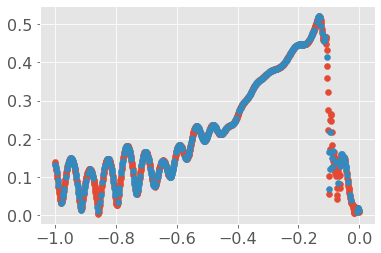

In [17]:
plt.figure()
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_val[:,0], y_val)

# create tf datasets

# base line

In [18]:
# fewer blocks seems like a good rule of thumb because the later blocks are very small

In [19]:
# i think that if 'activation' is relu then you can go deep and also get better accuracy compared with 's2relu'
# but 'scale_activation' is important to use 's2relu'

In [20]:
# scales = [1,10,50,100,500]
# scales = [1]
# scales = [1, 10]
scales = [1,10,50]
# scales = [1, 2, 5, 10, 20, 50, 100, 500]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 12
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"


model_params_dict = dict(
    input_shape=2,
    output_shape=1,
    units=units,
    activation=activation,
    scale_activation=scale_activation,
    n_blocks=n_blocks,
    scales=scales,
    layers_per_block=layers_per_block,
    scale_dimension=0,
    dtype=None,
    skip_connection=False,
    skip_connection_dense=False,
    final_dense=False,
)


In [21]:
test_model = get_compiled_custom_model(model_params_dict=model_params_dict, lr=1e-3)

In [22]:
callbacks = [
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    wispy.callbacks.ThresholdCallback(1e-6),
    tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
]

In [586]:
%%time
test_history = test_model.fit(x=X_train, y=y_train, epochs=2001, validation_data=(X_val, y_val), verbose=0, batch_size=200, callbacks=callbacks)

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

CPU times: user 1min 18s, sys: 23 s, total: 1min 41s
Wall time: 31.6 s


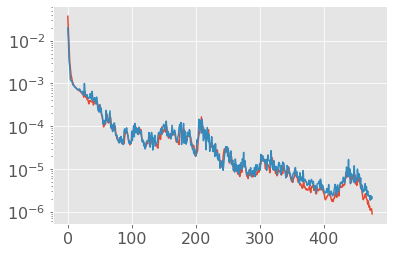

In [587]:
plt.figure()
plt.plot(test_history.history['loss'])
plt.plot(test_history.history['val_loss'])
plt.yscale('log')

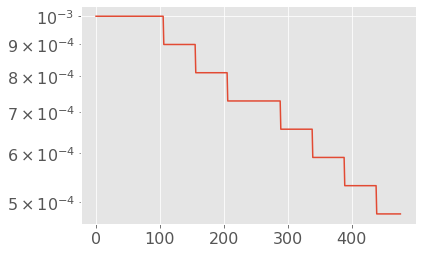

In [588]:
plt.figure()
plt.plot(test_history.history['lr'])
plt.yscale('log')

In [589]:
test_yhat = test_model.predict(X_train)

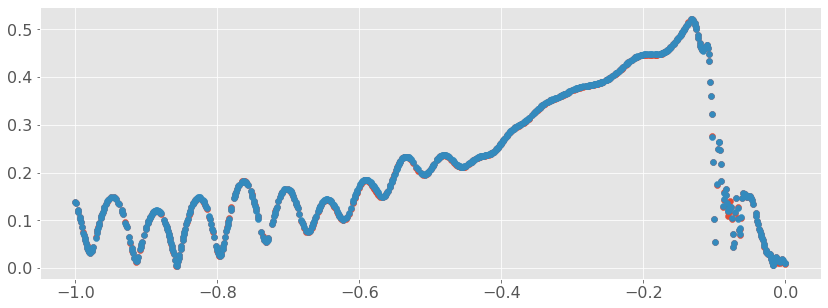

In [590]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_train[:,0], test_yhat)
# plt.xlim(-0.2, 0)

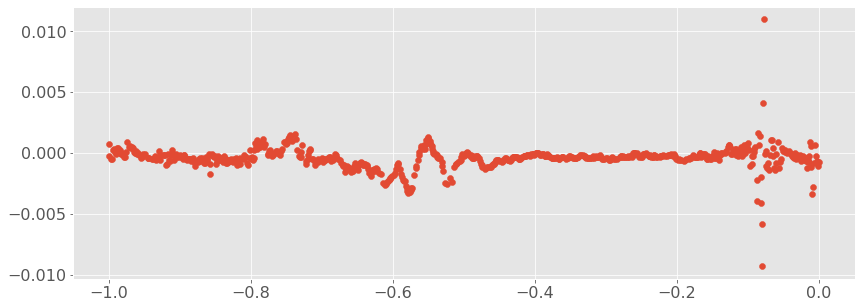

In [591]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], y_train-test_yhat)

(1e-13, 0.001)

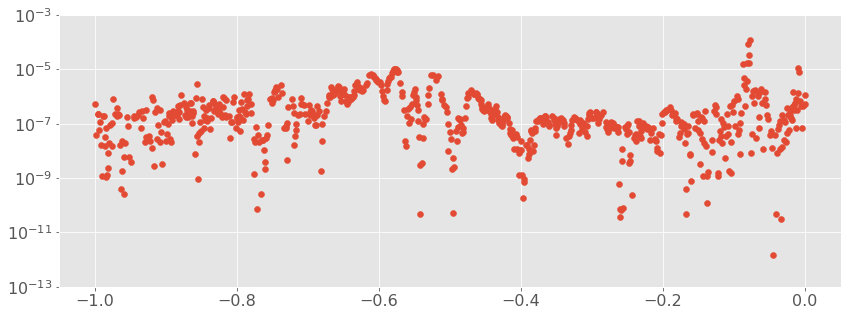

In [592]:
plt.figure(figsize=(14, 5))
plt.scatter(X_train[:,0], tf.keras.losses.mean_squared_error(y_train,test_yhat))
plt.yscale('log')
plt.ylim(1e-13, 1e-3)

In [593]:
# intermediate outputs

In [594]:
test_model.summary()

Model: "model_167"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_263 (ScaleLayer)    (None, 2)            0           input_57[0][0]                   
__________________________________________________________________________________________________
scale_layer_264 (ScaleLayer)    (None, 2)            0           input_57[0][0]                   
__________________________________________________________________________________________________
scale_layer_265 (ScaleLayer)    (None, 2)            0           input_57[0][0]                   
__________________________________________________________________________________________

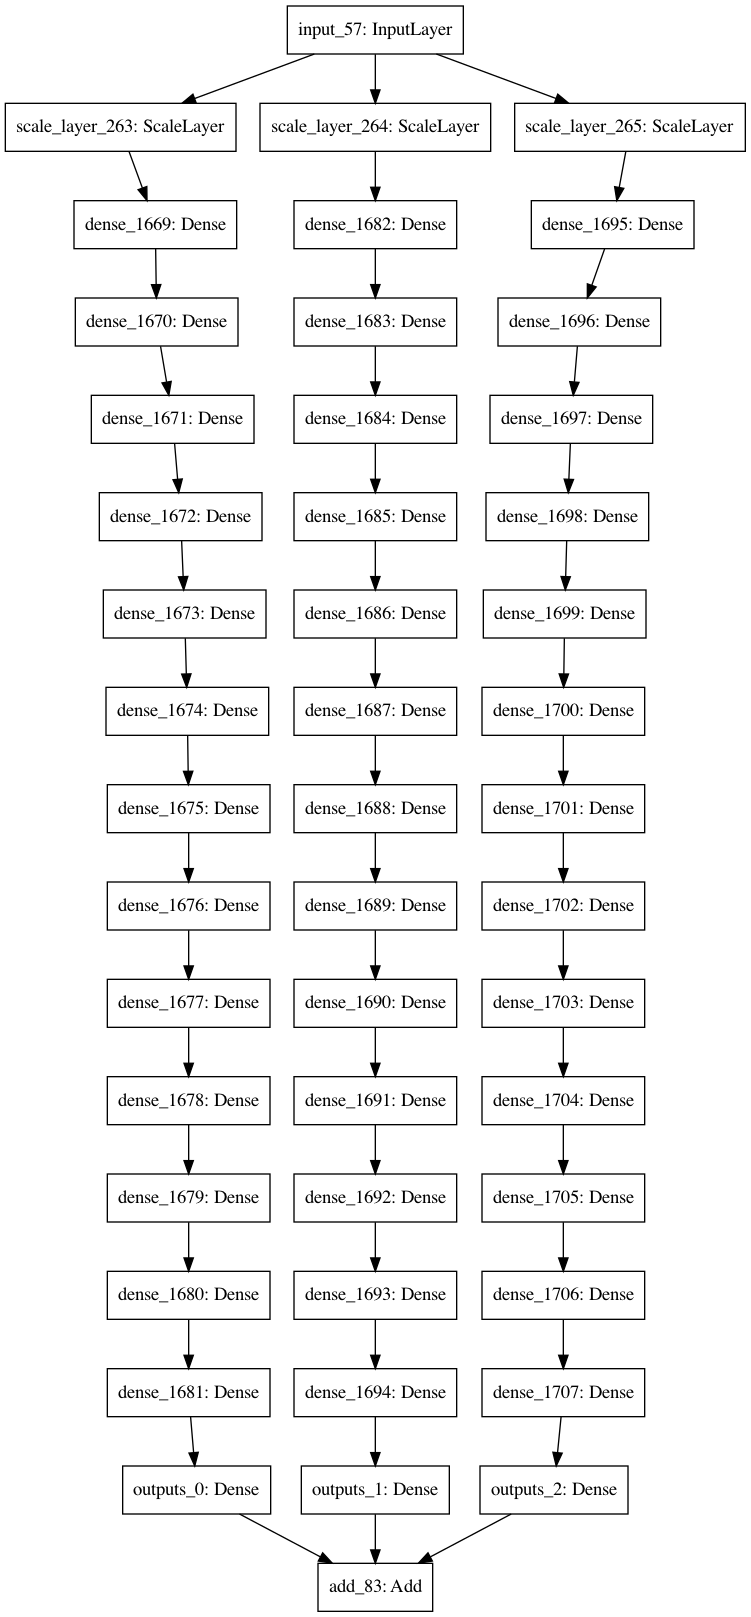

In [595]:
tf.keras.utils.plot_model(test_model)

In [596]:
n_blocks

[1, 1, 1]

In [597]:
int_model = {}
layer_names = [f"outputs_{i}" for i in range(n_scales)]
for layer_name in layer_names:
    print(layer_name)
    layer_output = test_model.get_layer(layer_name).output
    int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

    
# for ii in range(n_scales):
#     layer_names = [f"outputs_{ii}_{k}" for k in range(n_blocks)]
#     for layer_name in layer_names:
#         layer_output = test_model.get_layer(layer_name).output
#         int_model[layer_name] = tf.keras.models.Model(test_model.input, outputs=layer_output)

outputs_0
outputs_1
outputs_2


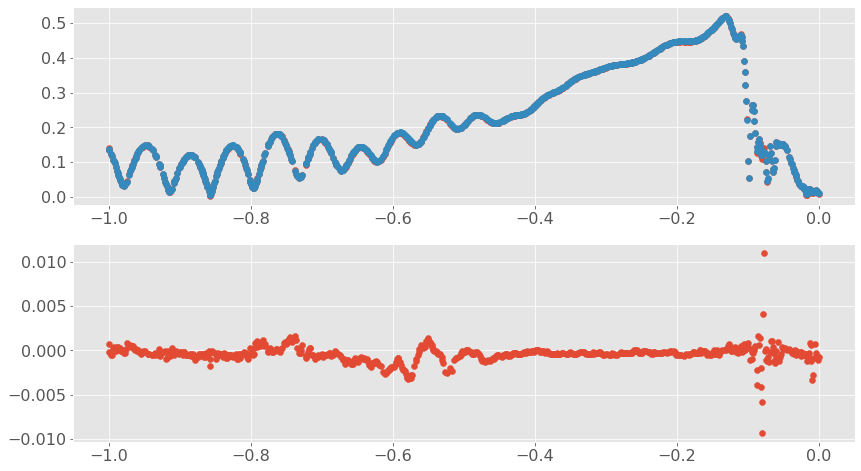

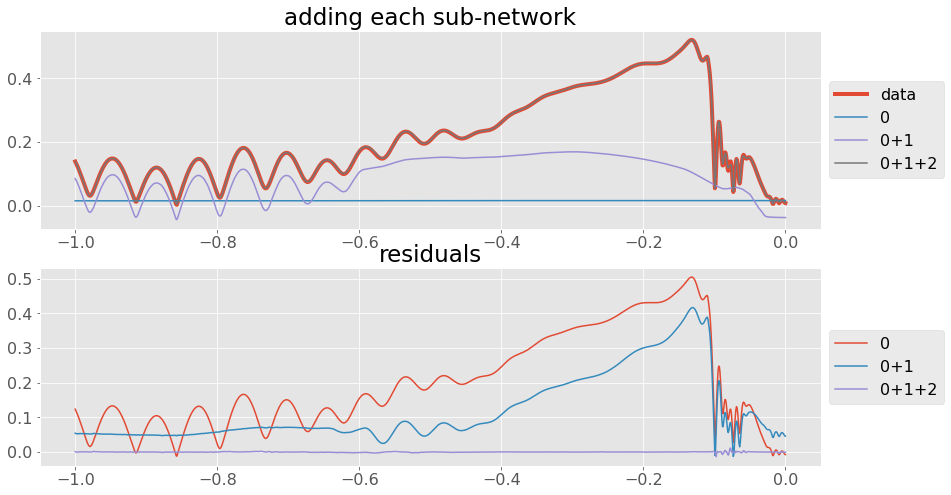

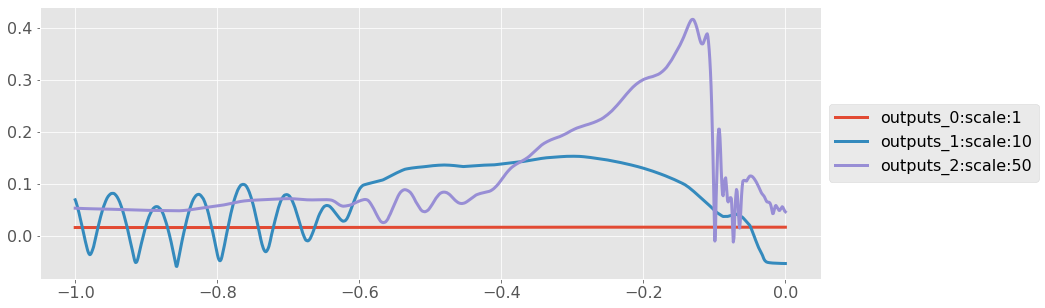

In [598]:
plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.scatter(X_train[:,0], y_train, label='data')
plt.scatter(X_train[:,0], test_yhat)
plt.subplot(2,1,2)
plt.scatter(X_train[:,0], y_train-test_yhat, label='data-pred')
plt.show()
plt.close()


plt.figure(figsize=(14, 8))
plt.subplot(2,1,1)
plt.plot(X_train_raw[:,0], y_train_raw, label='data', lw=4)
for i in range(1, n_scales+1):
    yy = np.sum([int_model[f"outputs_{ii}"].predict(X_train_raw) for ii in range(i)], axis=0)
    plt.plot(X_train_raw[:,0], yy[:,0], label="+".join([f"{ii}" for ii in range(i)]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('adding each sub-network')

plt.subplot(2,1,2)
for i in range(1, n_scales+1):
    yy = np.sum([int_model[f"outputs_{ii}"].predict(X_train_raw) for ii in range(i)], axis=0)
    plt.plot(X_train_raw[:,0], y_train_raw[:,0]-yy[:,0], label="+".join([f"{ii}" for ii in range(i)]))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('residuals')
plt.show()
plt.close()



plt.figure(figsize=(14, 5))
for i in range(n_scales):
    plt.plot(X_train_raw[:,0], int_model[f"outputs_{i}"].predict(X_train_raw), label=f"outputs_{i}:scale:{scales[i]}", lw=3)    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# int_summed = int_model["outputs_0"].predict(X_train_raw) + int_model["outputs_1"].predict(X_train_raw) + int_model["outputs_2"].predict(X_train_raw)
# plt.plot(X_train_raw[:,0], int_summed)

# for ii in range(n_scales):
#     plt.figure(figsize=(14, 5))
#     plt.plot(X_train_raw[:,0], int_model[f"outputs_{ii}"].predict(X_train_raw), label=f"outputs_{ii}:scale:{scales[ii]}", lw=3)  
#     for k in range(n_blocks):
#         plt.plot(X_train_raw[:,0], int_model[f"outputs_{ii}_{k}"].predict(X_train_raw), label=f"outputs_{ii}_{k}")
#     plt.title(f"scale: {scales[ii]}")
#     plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     plt.show()
#     plt.close()

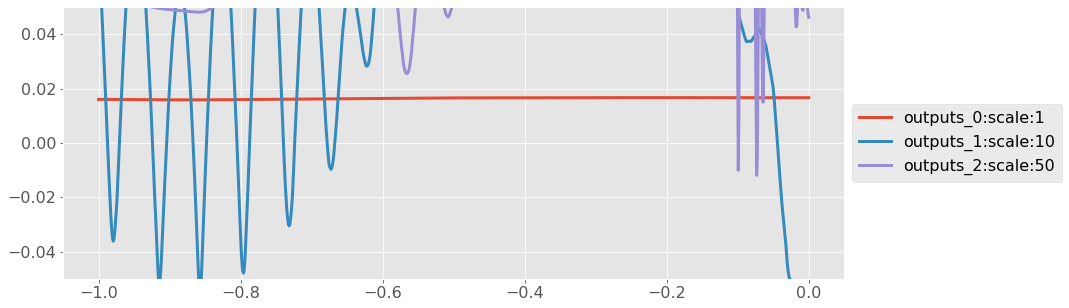

In [599]:
plt.figure(figsize=(14, 5))
for i in range(n_scales):
    plt.plot(X_train_raw[:,0], int_model[f"outputs_{i}"].predict(X_train_raw), label=f"outputs_{i}:scale:{scales[i]}", lw=3)    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-0.05,0.05)
plt.show()

# looping

In [24]:
models = {}
historys = {}

## model_1 

In [30]:
%%time

name = 'model_1'

models[name] = []
historys[name] = []

n_tries = 5
lr = 1e-3
batch_size = 200
epochs = 2001
scales = [1,10,50]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 12
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    
    curr_m = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)

    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
    ]
    curr_h = curr_m.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    historys[name].append(curr_h)
    models[name].append(curr_m)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 1/5 [00:41<02:46, 41.74s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 2/5 [01:26<02:09, 43.28s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 3/5 [02:25<01:41, 50.53s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 4/5 [02:48<00:39, 39.65s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 5/5 [03:09<00:00, 37.88s/it]

CPU times: user 7min 44s, sys: 2min 8s, total: 9min 52s
Wall time: 3min 9s


Text(0.5, 1.0, 'val')

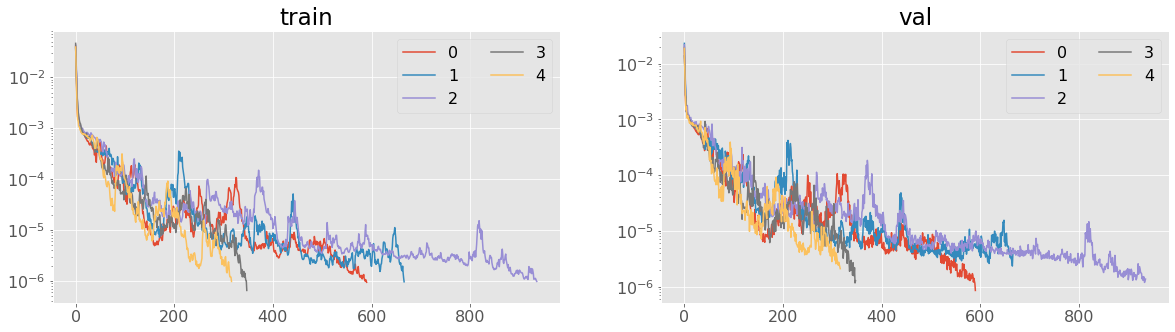

In [31]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'lr')

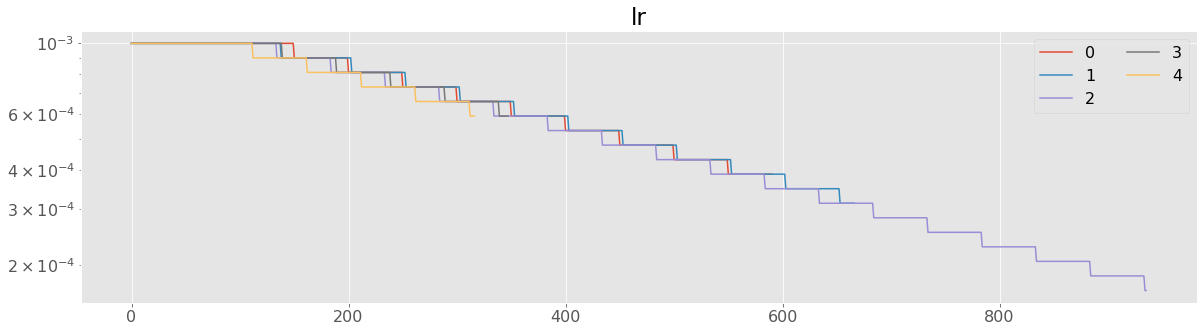

In [90]:
plt.figure(figsize=(20,5))
for i, history in enumerate(historys[name]):
    plt.plot(history.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('lr')

## model_2

In [32]:
%%time

name = 'model_2'

models[name] = []
historys[name] = []

n_tries = 5
lr = 1e-3
batch_size = 200
epochs = 2001
scales = [1,10,50]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 3
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    
    curr_m = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)

    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
    ]
    curr_h = curr_m.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    historys[name].append(curr_h)
    models[name].append(curr_m)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 1/5 [00:36<02:25, 36.41s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 2/5 [01:30<02:20, 46.84s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 3/5 [02:22<01:38, 49.17s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 4/5 [03:16<00:51, 51.18s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 5/5 [04:42<00:00, 56.49s/it]

CPU times: user 7min 53s, sys: 2min 26s, total: 10min 19s
Wall time: 4min 42s


Text(0.5, 1.0, 'val')

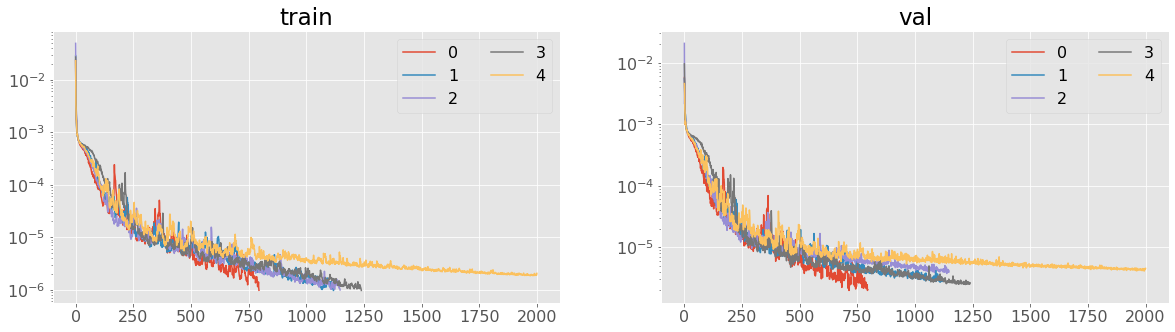

In [34]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'lr')

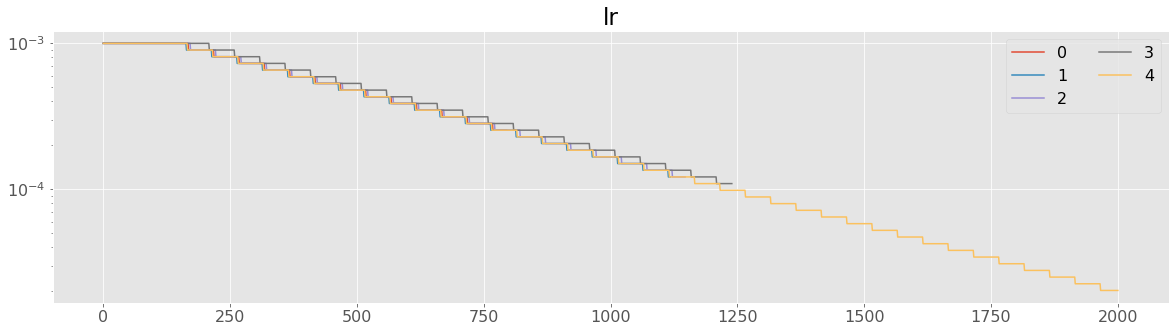

In [89]:
plt.figure(figsize=(20,5))
for i, history in enumerate(historys[name]):
    plt.plot(history.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('lr')

## model_3

In [84]:
%%time

name = 'model_3'

models[name] = []
historys[name] = []

n_tries = 1
lr = 1e-3
batch_size = 200
epochs = 801
scales = [1,10,50]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 3
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"

learning_rate_fn = tf.keras.experimental.CosineDecayRestarts(
    initial_learning_rate=lr,
    first_decay_steps=200,
    t_mul=1.0,
    m_mul=0.6,
    alpha=0.0)
lrs_callback = tf.keras.callbacks.LearningRateScheduler(learning_rate_fn)
# lrs_callback = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)



for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    
    curr_m = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)

    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        lrs_callback

    ]
    curr_h = curr_m.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    historys[name].append(curr_h)
    models[name].append(curr_m)

  0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|           0/801 ETA: ?s,  ?epochs/s

100%|██████████| 1/1 [00:40<00:00, 40.48s/it]

CPU times: user 1min 4s, sys: 20.8 s, total: 1min 25s
Wall time: 40.5 s


Text(0.5, 1.0, 'val')

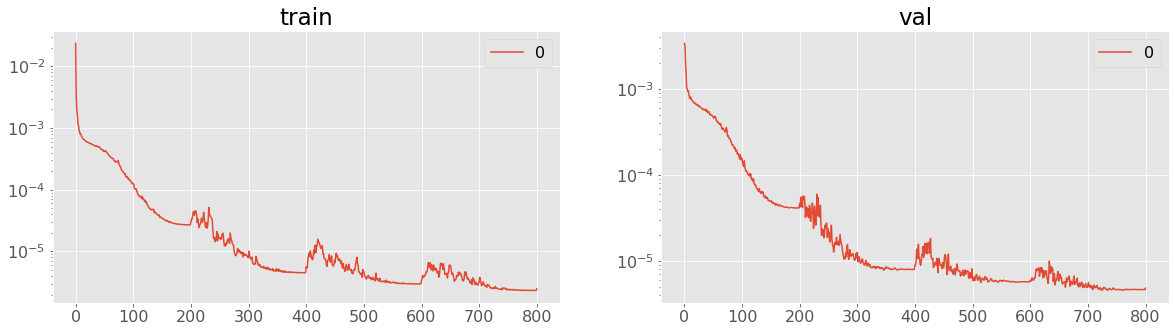

In [87]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'lr')

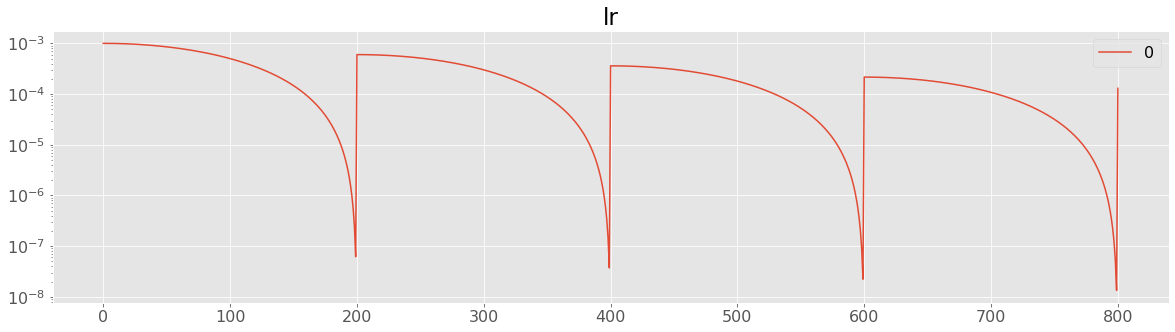

In [88]:
plt.figure(figsize=(20,5))
for i, history in enumerate(historys[name]):
    plt.plot(history.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('lr')

## model_4

In [91]:
%%time

name = 'model_4'

models[name] = []
historys[name] = []

n_tries = 5
lr = 1e-3
batch_size = 200
epochs = 2001
scales = [1,10,50]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 20
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    
    curr_m = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)

    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
    ]
    curr_h = curr_m.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    historys[name].append(curr_h)
    models[name].append(curr_m)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 1/5 [00:47<03:09, 47.36s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 2/5 [03:49<06:19, 126.39s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 3/5 [05:18<03:39, 109.54s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 4/5 [06:30<01:34, 94.62s/it] 

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 5/5 [07:21<00:00, 88.30s/it]

CPU times: user 19min 12s, sys: 6min 5s, total: 25min 17s
Wall time: 7min 21s


Text(0.5, 1.0, 'val')

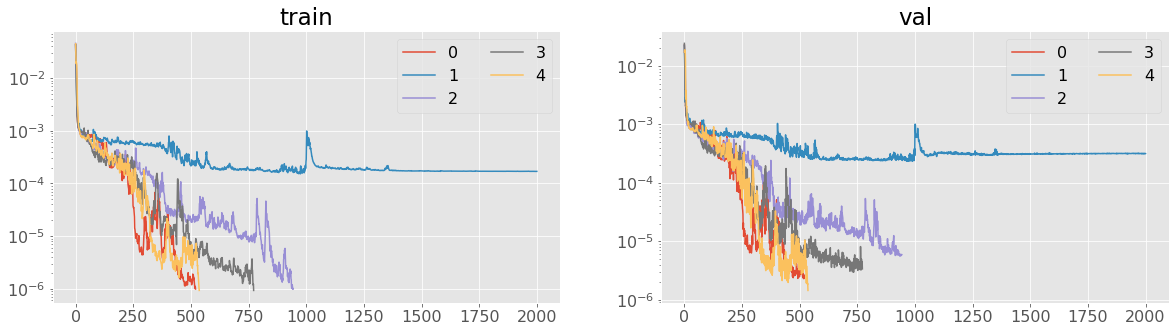

In [92]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'lr')

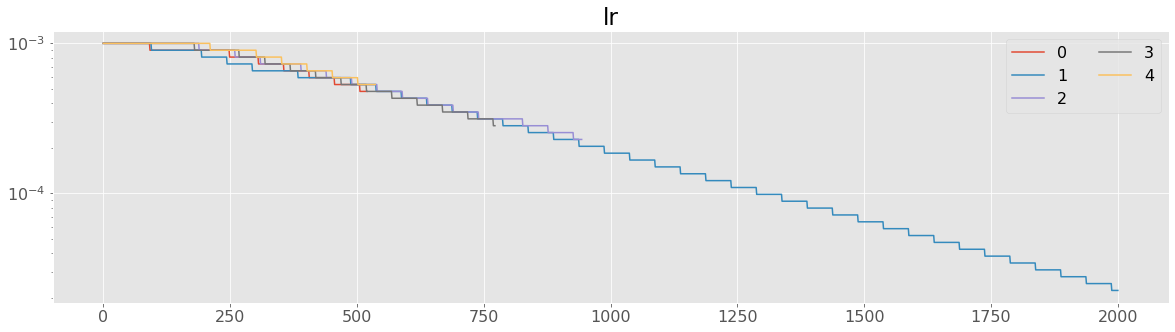

In [93]:
plt.figure(figsize=(20,5))
for i, history in enumerate(historys[name]):
    plt.plot(history.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('lr')

## model_5

In [102]:
%%time

name = 'model_5'

models[name] = []
historys[name] = []

n_tries = 5
lr = 1e-3
batch_size = 200
epochs = 2001
scales = [1,10,50]
n_scales = len(scales)
n_blocks = [1] * n_scales
layers_per_block = 3
units = [128] * n_scales
activation = "relu"
scale_activation="s2relu"
for i in tqdm.tqdm(range(n_tries)):
    model_params_dict = dict(
        input_shape=2,
        output_shape=1,
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=True,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    
    curr_m = get_compiled_custom_model(model_params_dict=model_params_dict, lr=lr)

    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(1e-6),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=50, factor=0.9)
    ]
    curr_h = curr_m.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_val, y_val), verbose=0, batch_size=batch_size, callbacks=callbacks)
    historys[name].append(curr_h)
    models[name].append(curr_m)

  0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 20%|██        | 1/5 [00:41<02:45, 41.43s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 40%|████      | 2/5 [01:35<02:26, 48.71s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 60%|██████    | 3/5 [02:40<01:52, 56.14s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

 80%|████████  | 4/5 [03:48<01:00, 60.81s/it]

Training:   0%|           0/2001 ETA: ?s,  ?epochs/s

100%|██████████| 5/5 [05:06<00:00, 61.34s/it]

CPU times: user 7min 43s, sys: 3min 3s, total: 10min 46s
Wall time: 5min 6s


Text(0.5, 1.0, 'val')

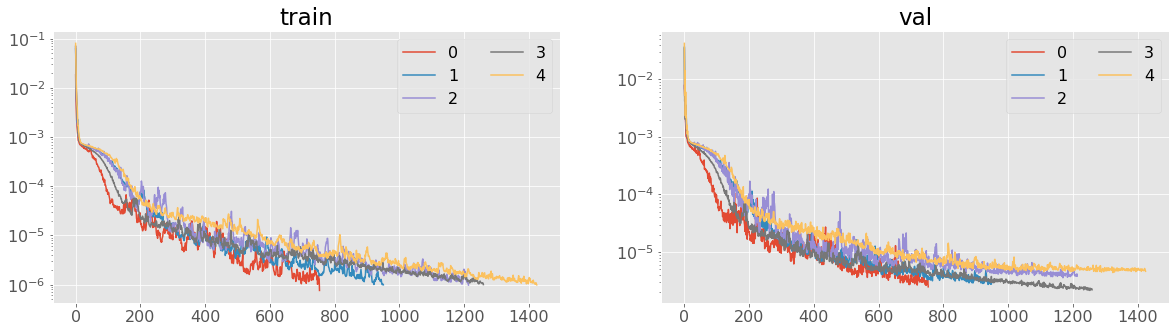

In [105]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('train')

plt.subplot(1,2,2)
for i, history in enumerate(historys[name]):
    plt.plot(history.history['val_loss'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('val')

Text(0.5, 1.0, 'lr')

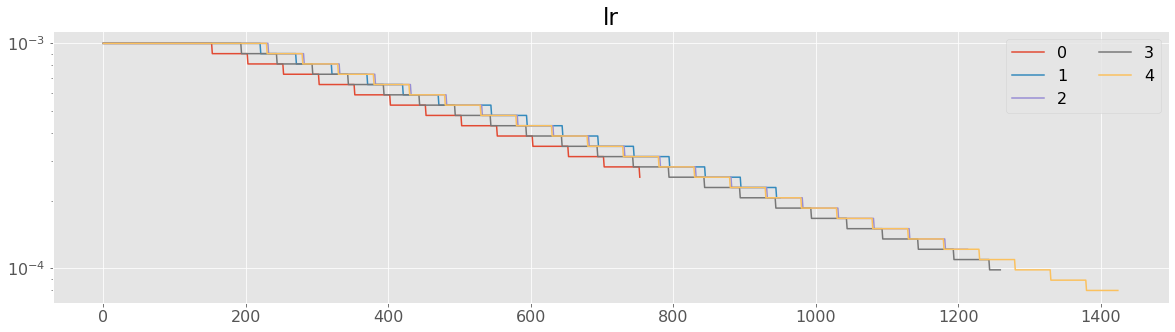

In [106]:
plt.figure(figsize=(20,5))
for i, history in enumerate(historys[name]):
    plt.plot(history.history['lr'], label=f'{i}')
plt.yscale('log')
plt.legend(ncol=2)
plt.title('lr')